In [ ]:
%%capture
!pip install opensmile
!pip install wandb
!pip install datasets
!pip install tqdm

In [ ]:
import pandas as pd
# import opensmile

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
root_folder = "gdrive/MyDrive/emotion_recognition/"
data_path = root_folder + "data_init/"
data_seg_path = root_folder + "data_init_segments/"
res_folder = root_folder + 'experiments/'
audio_features_folder = res_folder + "audio_features/"

# Evaluation functions

In [ ]:
import wandb
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt

def evaluate(y_true, y_pred, run, display_cm=True, display_cr=True):
    # print(f"f1-score: {round(f1_score(y_true, y_pred, average='binary'),2)}, accuracy: {round(accuracy_score(y_true, y_pred),2)}")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    if display_cm:
      disp = ConfusionMatrixDisplay(confusion_matrix=cm)
      disp.plot()
      plt.show()

    if display_cr:
      cr = classification_report(y_true, y_pred)
      print(cr)

    if run:
      wandb.sklearn.plot_confusion_matrix(y_true, y_pred)

      cr = classification_report(y_true, y_pred, output_dict=True)
      run.log({"accuracy" : cr['accuracy'],
              "no_conflict_precision" : cr['no-conflict']['precision'],
              "no_conflict_recall" : cr['no-conflict']['recall'],
              "no_conflict_f1-score" : cr['no-conflict']['f1-score'],
              "conflict_precision" : cr['conflict']['precision'],
              "conflict_recall" : cr['conflict']['recall'],
              "conflict_f1-score" : cr['conflict']['f1-score']})

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import time


def cross_validation_n_fold(clf, values, true_labels, wandb_config=None, cv=5):
  run = None
  if wandb_config:
    timestr = time.strftime("%m%d-%H%M")
    run = wandb.init(project="emotion_recognition",
              name=f"e_{timestr}_audio_eval",
              config=wandb_config)

  # score = cross_val_score(clf, values, true_labels, cv=5)

  pred = cross_val_predict(clf, values, true_labels, cv=5)

  evaluate(true_labels, pred, run)

  if wandb_config:
    wandb.finish()
  # print(score)
  # print(confusion_matrix(true_labels, pred))
  # print(classification_report(true_labels, pred))

In [ ]:
def fold_i_of_k(meta_df, seg_features, i, k):
    n = len(meta_df)

    return meta_df[n*(i-1)//k:n*i//k]


def manual_k_fold(clf, df_seg, df_seg_features, name='pred_compare_func', wandb_config=None, cv=5):
  run=None
  if wandb_config:
    timestr = time.strftime("%m%d-%H%M")
    run = wandb.init(project="emotion_recognition",
              name=f"e_{timestr}_audio_eval",
              config=wandb_config)

  for i in range(1, cv+1):
    fold_i_of_k(df_file, df_seg, i, cv)
    k_fold = df_seg[df_seg['conversation_folder_name'].isin(fold_i_of_k(df_file, df_seg, i, cv).folder_name)]
    features_test = df_seg_features[df_seg_features['path'].isin(k_fold.path)].copy()
    features_train = df_seg_features[~df_seg_features['path'].isin(k_fold.path)].copy()

    clf.fit(features_train.drop(columns=['path', 'label']),
                  features_train['label'])
    try:
      pred = clf.predict(features_test.drop(columns=['path', 'label']))
    except:
      display(features_test)

    df_seg.loc[k_fold.index, name] = pred
  print(df_seg[name].value_counts())
  df_res = df_seg[['conversation_folder_name', 'context_label', 'label', name]] \
            .groupby(['conversation_folder_name', 'context_label'])[name] \
            .apply(lambda x: 'conflict' if 'conflict' in list(x.values) else 'no-conflict').reset_index()

  evaluate(df_res['context_label'], df_res[name], run=run)


  if wandb_config:
    run.finish()

In [ ]:
wandb.login()

wandb_config = {
    "model_name" : "",
    "fine-tuned" : False,
    "framework" : "sklearn",
    "data" : "init_full_1h",
    "feature_set" : "ComParE_2016",
    "feature_level" : "func",
    "task" : "audio_classification",
    "split" : "no",
    "CV" : "n-fold"
  }

# Data preparation

In [ ]:
df_file = pd.read_csv(res_folder+'init.csv', ).reset_index(drop=True)


df_file['emotion_merged'] = df_file['emotion']
df_file.loc[df_file['emotion_merged'] == 'pleasant_surprise', 'emotion_merged'] = 'happy'
df_file.loc[df_file['emotion_merged'] == 'disgust', 'emotion_merged'] = 'angry'
df_file['label'] = df_file['emotion_merged'].apply(lambda x: 'no-conflict' if x in ['neutral', 'happy'] else 'conflict')
df_file['path'] = data_path + df_file['folder_name'] + '/' + "rs_16_" + df_file['audio_file_name']
df_file['folder'] = df_file.path.str.split('/').str[4]

df_file = df_file.drop(columns=['Unnamed: 0', 'emotion'])


In [ ]:
def change_lang(lang, langid_lang):
  if lang == 's':
    if langid_lang == 'ru':
      return 'r'
    return 'u'
  return lang


df_seg = pd.read_csv(data_seg_path+'seg_info.csv').drop([48]).reset_index(drop=True)
df_seg['emotion_merged'] = df_seg['emotion']
df_seg.loc[df_seg['emotion_merged'] == 'pleasant_surprise', 'emotion_merged'] = 'happy'
df_seg.loc[df_seg['emotion_merged'] == 'disgust', 'emotion_merged'] = 'angry'
df_seg['label'] = df_seg['emotion_merged'].apply(lambda x: 'no-conflict' if x in ['neutral', 'happy'] else 'conflict')
df_seg['context_label'] = df_seg['emotion_context'].apply(lambda x: 'no-conflict' if x in ['neutral', 'happy', 'pleasant_surprise'] else 'conflict')

df_seg['language'] = df_seg.apply(lambda row: change_lang(row['language'], row['langid_language']),
                                  axis=1)
df_seg['path'] = df_seg['folder_name'] + df_seg['res_file_name']

df_seg = df_seg.drop(columns=['Unnamed: 0', 'folder_name', 'file_name',
                              'info', 'emotion', 'langid_language'])

# opensmile features

## Feature extraction

### opensmile (audio ComParE_2016)

In [ ]:
import opensmile

In [ ]:
smile = opensmile.Smile(
    opensmile.FeatureSet.ComParE_2016,
    opensmile.FeatureLevel.Functionals,
    sampling_rate=16000,
    resample=False, # audio already was resampled
    num_workers=5,
    verbose=True,
)


In [ ]:
df_file_smile_func_compare = smile.process_files(list(df_file['path'].values))
df_file_smile_func_compare.to_csv(audio_features_folder+'file_smile_func_compare.csv')

In [ ]:
df_seg_smile_func_compare = smile.process_files(list(df_seg['path'].values))
df_seg_smile_func_compare.to_csv(audio_features_folder+'seg_smile_func_compare.csv')

In [ ]:
df_file_smile_lld_compare = smile.process_files(list(df_file['path'].values))
df_file_smile_lld_compare.to_csv(audio_features_folder+'file_smile_lld_compare.csv')

In [ ]:
df_seg_smile_lld_compare = smile.process_files(list(df_seg['path'].values))
df_seg_smile_lld_compare.to_csv(audio_features_folder+'seg_smile_lld_compare.csv')

## helper funtions

In [ ]:
def merge_labels(df_meta, df_features, drop_index=False, merge_on="path"):
  return df_features.reset_index(drop=drop_index) \
                    .rename(columns={"file":"path"}) \
                    .merge(df_meta[[merge_on, 'label']], on=merge_on, how='inner', suffixes=('_1', '_2'))

In [ ]:
df_file_smile_func_compare = pd.read_csv(audio_features_folder+'file_smile_func_compare.csv')
df_seg_smile_func_compare = pd.read_csv(audio_features_folder+'seg_smile_func_compare.csv')
df_file_smile_lld_compare = pd.read_csv(audio_features_folder+'file_smile_lld_compare.csv')
df_seg_smile_lld_compare = pd.read_csv(audio_features_folder+'seg_smile_lld_compare.csv')

In [ ]:
df_file_smile_func_compare = merge_labels(df_file, df_file_smile_func_compare, drop_index=True)
df_seg_smile_func_compare = merge_labels(df_seg, df_seg_smile_func_compare, drop_index=True)

## SVC

[[30 14]
 [11 35]]


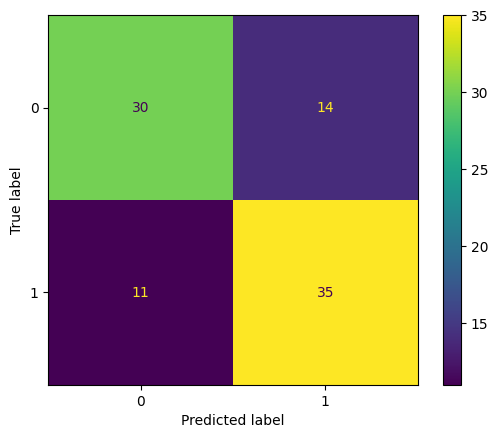

              precision    recall  f1-score   support

    conflict       0.73      0.68      0.71        44
 no-conflict       0.71      0.76      0.74        46

    accuracy                           0.72        90
   macro avg       0.72      0.72      0.72        90
weighted avg       0.72      0.72      0.72        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.72222
conflict_f1-score,0.70588
conflict_precision,0.73171
conflict_recall,0.68182


In [ ]:
from sklearn.svm import SVC

wandb_config['model_name'] = "SVC"
wandb_config['feature_level'] = "func"

clf = make_pipeline(
    StandardScaler(),
    SVC(gamma='auto'),
)

cross_validation_n_fold(clf, df_file_smile_func_compare.drop(columns=['path', 'start', 'end', 'label']),
               df_file_smile_func_compare['label'], wandb_config)

[[30 14]
 [11 35]]


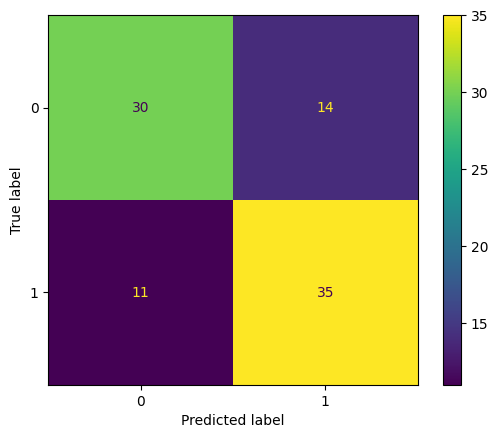

              precision    recall  f1-score   support

    conflict       0.73      0.68      0.71        44
 no-conflict       0.71      0.76      0.74        46

    accuracy                           0.72        90
   macro avg       0.72      0.72      0.72        90
weighted avg       0.72      0.72      0.72        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.72222
conflict_f1-score,0.70588
conflict_precision,0.73171
conflict_recall,0.68182


In [ ]:
wandb_config['model_name'] = "SVC"
wandb_config['feature_level'] = "lld"

df_file_smile_lld_compare = merge_labels(df_file, df_file_smile_lld_compare, drop_index=False)


clf = make_pipeline(
    StandardScaler(),
    SVC(gamma='auto'),
)

cross_validation_n_fold(clf, df_file_smile_lld_compare.drop(columns=['path', 'start', 'end', 'label']),
               df_file_smile_lld_compare['label'], wandb_config)

#### Segments

[[ 25 103]
 [  5 412]]


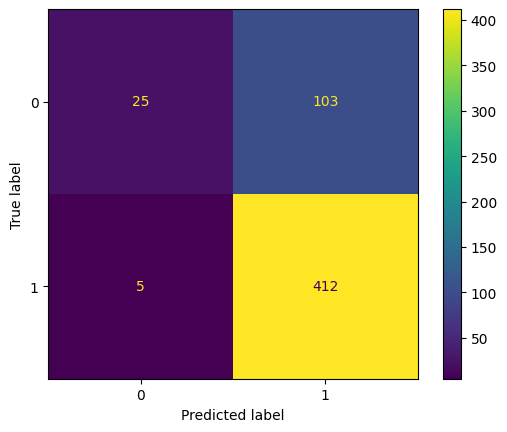

              precision    recall  f1-score   support

    conflict       0.83      0.20      0.32       128
 no-conflict       0.80      0.99      0.88       417

    accuracy                           0.80       545
   macro avg       0.82      0.59      0.60       545
weighted avg       0.81      0.80      0.75       545



In [ ]:
from sklearn.svm import SVC

wandb_config['model_name'] = "SVC"
wandb_config['feature_level'] = "func"
wandb_config['data'] = "init_1h_seg"

clf = make_pipeline(
    StandardScaler(),
    SVC(gamma='auto'),
)

cross_validation_n_fold(clf, df_seg_smile_func_compare.drop(columns=['path', 'start', 'end', 'label']),
               df_seg_smile_func_compare['label'], None)

pred_compare_func
no-conflict    517
conflict        28
Name: count, dtype: int64
[[18 21]
 [ 2 44]]


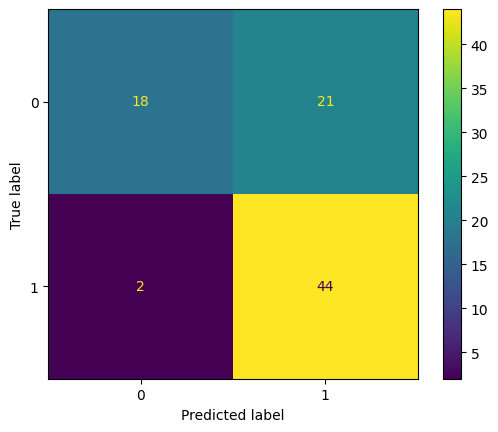

              precision    recall  f1-score   support

    conflict       0.90      0.46      0.61        39
 no-conflict       0.68      0.96      0.79        46

    accuracy                           0.73        85
   macro avg       0.79      0.71      0.70        85
weighted avg       0.78      0.73      0.71        85



In [ ]:
wandb_config['model_name'] = "SVC"
wandb_config['feature_level'] = "func"
wandb_config['data'] = "init_1h_seg"
wandb_config['split'] = "per-file-all"


clf = make_pipeline(
    StandardScaler(),
    SVC(gamma='auto'),
)

manual_k_fold(clf, df_seg, df_seg_smile_func_compare.drop(columns=['start', 'end']), name='pred_compare_func', wandb_config=None, cv=5)


pred_compare_func
no-conflict    287
conflict        22
Name: count, dtype: int64
[[15 24]
 [ 1 44]]


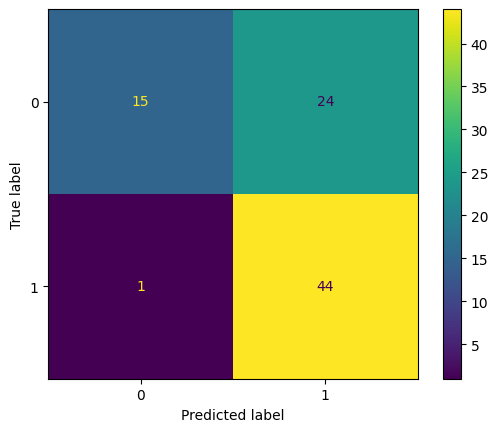

              precision    recall  f1-score   support

    conflict       0.94      0.38      0.55        39
 no-conflict       0.65      0.98      0.78        45

    accuracy                           0.70        84
   macro avg       0.79      0.68      0.66        84
weighted avg       0.78      0.70      0.67        84



In [ ]:
wandb_config['model_name'] = "SVC"
wandb_config['feature_level'] = "func"
wandb_config['data'] = "init_1h_seg"
wandb_config['split'] = "per-file-clients-only"


clf = make_pipeline(
    StandardScaler(),
    SVC(gamma='auto'),
)

manual_k_fold(clf, df_seg[df_seg['speaker'] != 's'], df_seg_smile_func_compare.drop(columns=['start', 'end']), name='pred_compare_func', wandb_config=None, cv=5)


## LR

In [ ]:
from sklearn.linear_model import LogisticRegression


wandb: Currently logged in as: patenko-pn (lp-ucu). Use `wandb login --relogin` to force relogin


[[33 11]
 [11 35]]


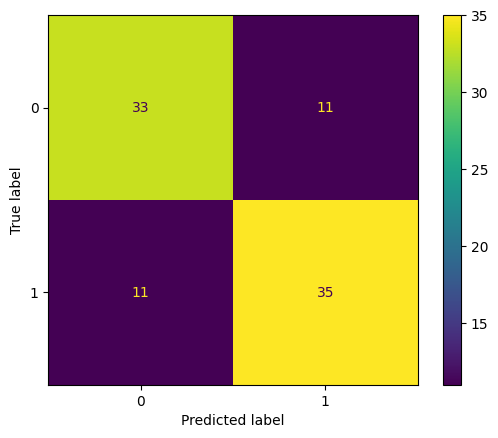

              precision    recall  f1-score   support

    conflict       0.75      0.75      0.75        44
 no-conflict       0.76      0.76      0.76        46

    accuracy                           0.76        90
   macro avg       0.76      0.76      0.76        90
weighted avg       0.76      0.76      0.76        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.75556
conflict_f1-score,0.75
conflict_precision,0.75
conflict_recall,0.75


In [ ]:
wandb_config['model_name'] = "LR"
wandb_config['feature_level'] = "func"
wandb_config['data'] = "init_full_1h"
wandb_config['split'] = "no"


clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0),
)

cross_validation_n_fold(clf, df_file_smile_func_compare.drop(columns=['path', 'start', 'end', 'label']),
               df_file_smile_func_compare['label'], wandb_config)

#### Segments

wandb: Currently logged in as: patenko-pn (lp-ucu). Use `wandb login --relogin` to force relogin


[[ 69  59]
 [ 34 383]]


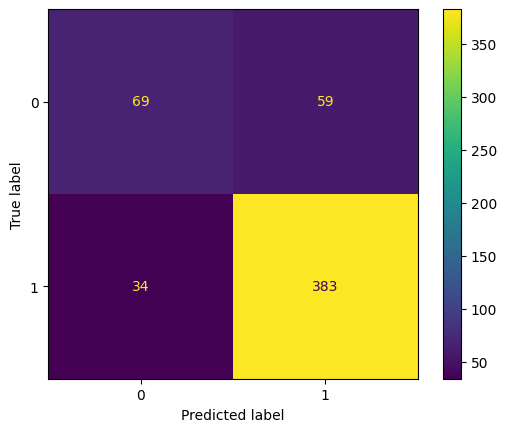

              precision    recall  f1-score   support

    conflict       0.67      0.54      0.60       128
 no-conflict       0.87      0.92      0.89       417

    accuracy                           0.83       545
   macro avg       0.77      0.73      0.74       545
weighted avg       0.82      0.83      0.82       545



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.82936
conflict_f1-score,0.5974
conflict_precision,0.6699
conflict_recall,0.53906


In [ ]:
wandb_config['model_name'] = "LR"
wandb_config['feature_level'] = "func"
wandb_config['data'] = "init_1h_seg"

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0, max_iter=1000),
)

cross_validation_n_fold(clf, df_seg_smile_func_compare.drop(columns=['path', 'start', 'end', 'label']),
               df_seg_smile_func_compare['label'], wandb_config)

pred_compare_func
no-conflict    440
conflict       105
Name: count, dtype: int64
[[34  5]
 [17 29]]


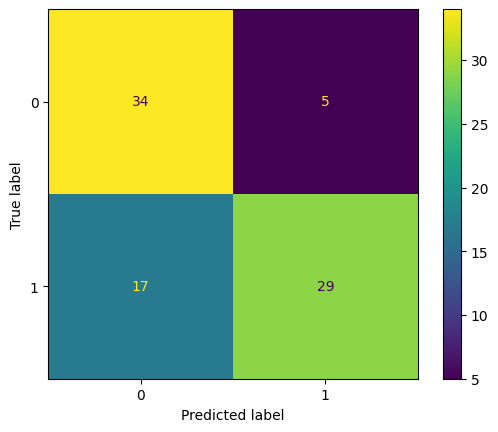

              precision    recall  f1-score   support

    conflict       0.67      0.87      0.76        39
 no-conflict       0.85      0.63      0.72        46

    accuracy                           0.74        85
   macro avg       0.76      0.75      0.74        85
weighted avg       0.77      0.74      0.74        85



In [ ]:
wandb_config['model_name'] = "LR"
wandb_config['feature_level'] = "func"
wandb_config['data'] = "init_1h_seg"
wandb_config['split'] = "per-file-all"
wandb_config['max_iter'] = 1000


clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0, max_iter=1000),
)

manual_k_fold(clf, df_seg, df_seg_smile_func_compare.drop(columns=['start', 'end']), name='pred_compare_func', wandb_config=None, cv=5)


pred_compare_func
no-conflict    219
conflict        90
Name: count, dtype: int64
[[34  5]
 [15 30]]


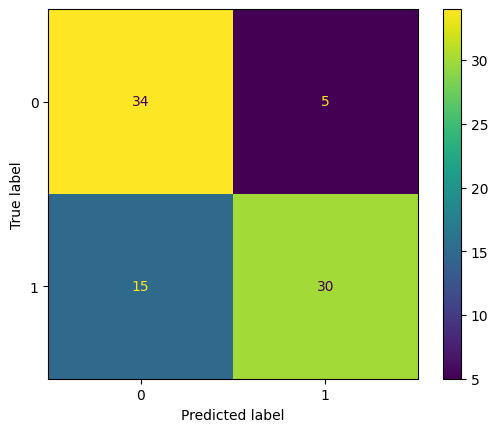

              precision    recall  f1-score   support

    conflict       0.69      0.87      0.77        39
 no-conflict       0.86      0.67      0.75        45

    accuracy                           0.76        84
   macro avg       0.78      0.77      0.76        84
weighted avg       0.78      0.76      0.76        84



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.7619
conflict_f1-score,0.77273
conflict_precision,0.69388
conflict_recall,0.87179


In [ ]:
wandb_config['model_name'] = "LR"
wandb_config['feature_level'] = "func"
wandb_config['data'] = "init_1h_seg"
wandb_config['split'] = "per-file-clients-only"
wandb_config['max_iter'] = 1000


clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0, max_iter=1000),
)

manual_k_fold(clf, df_seg[df_seg['speaker'] != 's'], df_seg_smile_func_compare.drop(columns=['start', 'end']), name='pred_compare_func', wandb_config=wandb_config, cv=5)


##### Pooling

In [ ]:
df_seg_smile_func_compare['folder_name'] = (df_seg_smile_func_compare['path']
                                       .str.split('/').str[-1]
                                       .str.split('_').str[2])

In [ ]:
df_seg_smile_func_compare_aggr = (df_seg_smile_func_compare
                                  .drop(columns=['label', 'path', 'start', 'end'])
                                  .groupby('folder_name').mean()).reset_index()

In [ ]:
df_seg_smile_func_compare_aggr = merge_labels(df_file, df_seg_smile_func_compare_aggr,
                                              drop_index=True, merge_on="folder_name")

[[18 21]
 [15 31]]


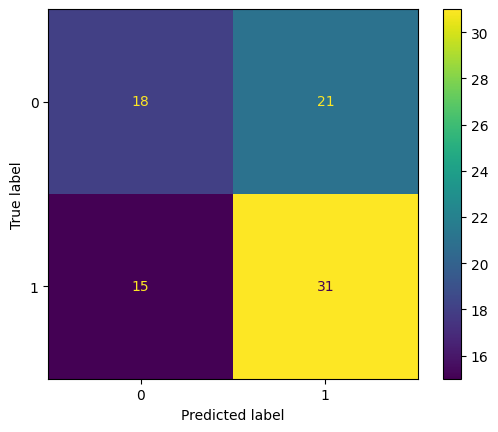

              precision    recall  f1-score   support

    conflict       0.55      0.46      0.50        39
 no-conflict       0.60      0.67      0.63        46

    accuracy                           0.58        85
   macro avg       0.57      0.57      0.57        85
weighted avg       0.57      0.58      0.57        85



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.57647
conflict_f1-score,0.5
conflict_precision,0.54545
conflict_recall,0.46154


In [ ]:
wandb_config['model_name'] = "LR"
wandb_config['feature_level'] = "func"
wandb_config['data'] = "init_1h_seg"
wandb_config['split'] = "avg-pooling"
wandb_config['max_iter'] = 1000


clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0, max_iter=1000),
)

cross_validation_n_fold(clf, df_seg_smile_func_compare_aggr.drop(columns=['folder_name','label']),
               df_seg_smile_func_compare_aggr['label'], wandb_config)

In [ ]:
#TODO:
#aggreagte features by folder (mean or max pooling) and try sklearn cros validation

# Wav2Vec2 features

In [ ]:
from tqdm import tqdm
import torch
import torchaudio
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Wav2Vec2FeatureExtractor
from datasets import load_dataset, load_metric

## Pre-trained models, without fine-tuing

### Data preparation

In [ ]:
df_file.columns

Index(['folder_name', 'audio_file_name', 'speech_duration', 'language',
       'origin_text', 'emotion_merged', 'label', 'path', 'folder'],
      dtype='object')

In [ ]:
df_file[['path', 'label']].to_csv('all_files.csv', sep="\t", encoding="utf-8", index=False)

df_seg[['path', 'label']].to_csv('seg.csv', sep="\t", encoding="utf-8", index=False)

In [ ]:
data_files = {
    "validation": 'all_files.csv',
    "validation_seg": 'seg.csv',
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
eval_dataset = dataset["validation"]
eval_seg_dataset = dataset["validation_seg"]


print(eval_dataset)
print(eval_seg_dataset)

Generating validation split: 0 examples [00:00, ? examples/s]

Generating validation_seg split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['path', 'label'],
    num_rows: 90
})
Dataset({
    features: ['path', 'label'],
    num_rows: 545
})


In [ ]:
input_column = "path"
output_column = "label"

In [ ]:
model_name = "facebook/wav2vec2-xls-r-300m"
# model_name = "facebook/wav2vec2-xls-r-1b"
# model_name = "facebook/wav2vec2-xls-r-2b"
# feature_extractor = Wav2Vec2Processor.from_pretrained(model_name)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-xls-r-300m and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# random weight initialization
for param in model.parameters():
    param.data.normal_(mean=0.0, std=model.config.initializer_range)

In [ ]:
target_sampling_rate = feature_extractor.sampling_rate
target_sampling_rate

16000

In [ ]:
def speech_file_to_array_fn(path):
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech

def label_to_id(label, label_list):

    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1

    return label

def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]]
    # target_list = [label_to_id(label, label_list) for label in examples[output_column]]

    result = feature_extractor(speech_list,
                        sampling_rate=target_sampling_rate,
                        #max_length=max_length,
                        #truncation=True,
                        #padding=True
                       )
    # result["labels"] = list(target_list)

    return result

In [ ]:
# num_proc > 1 colab might just stuck forever. Smth about lost .join()
eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=4,
    batched=True,
    num_proc=1
)

eval_seg_dataset = eval_seg_dataset.map(
    preprocess_function,
    batch_size=4,
    batched=True,
    num_proc=1
)

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Map:   0%|          | 0/545 [00:00<?, ? examples/s]

In [ ]:
def extract_embeddings(model, dataset, df, prefix="file_", model_prefix="w2v_no-tune_fb_xls-r-300m"):
  # it is longer, but it is not clear how to properly use padding together with mean pooling
  hidden_states_list = []
  extract_features_list = []

  # for i in tqdm(range(2)):
  for i in tqdm(range(len(dataset))):
    input = feature_extractor(dataset[i]["input_values"],
                        return_tensors="pt", sampling_rate=16000)
    with torch.no_grad():
      output = model(**input)

    hidden_states_list.append(torch.mean(output['last_hidden_state'], dim=1)[0])
    extract_features_list.append(torch.mean(output['extract_features'], dim=1)[0])


  df_hs = (pd.concat([df,pd.DataFrame(columns=['hs_'+str(i)
                for i in range(len(hidden_states_list[0]))])],axis=1,sort=False))
  df_hs.loc[:,'hs_0':] = hidden_states_list
  csv_file_name = prefix + "hs_" + model_prefix + ".csv"
  print(f"saving hidden states to {csv_file_name} file")
  df_hs.to_csv(audio_features_folder+csv_file_name)

  df_ef = (pd.concat([df,pd.DataFrame(columns=['ef_'+str(i)
                for i in range(len(extract_features_list[0]))])],axis=1,sort=False))
  df_ef.loc[:,'ef_0':] = extract_features_list
  csv_file_name = prefix + "ef_" + model_prefix + ".csv"
  print(f"saving extracted features to {csv_file_name} file")
  df_ef.to_csv(audio_features_folder+csv_file_name)

  return df_hs, df_ef

In [ ]:
df_file_hs, df_file_ef = extract_embeddings(model,
                                          eval_dataset,
                                          df_file, prefix="file_",
                                          model_prefix=model_name.split('/')[1])

100%|██████████| 90/90 [28:46<00:00, 19.19s/it]

saving hidden states to file_hs_wav2vec2-xls-r-300m.csv file
saving extracted features to file_ef_wav2vec2-xls-r-300m.csv file


In [ ]:
df_seg_hs, df_seg_ef = extract_embeddings(model,
                                          eval_seg_dataset,
                                          df_seg, prefix="seg_",
                                          model_prefix=model_name.split('/')[1])

100%|██████████| 545/545 [13:37<00:00,  1.50s/it]


saving hidden states to seg_hs_wav2vec2-xls-r-300m.csv file
saving extracted features to seg_ef_wav2vec2-xls-r-300m.csv file


In [ ]:
hs_seg_list, ef_seg_list = extract_embeddings(model, eval_seg_dataset)


In [ ]:
df_seg_hs = (pd.concat([df_seg,pd.DataFrame(columns=['hs_'+str(i)
               for i in range(1024)])],axis=1,sort=False))
df_seg_hs.loc[:,'hs_0':] = hs_seg_list

df_seg_hs.to_csv(audio_features_folder+'seg_hs_w2v_no-tune_fb_xls-r-300m.csv')

In [ ]:
df_seg_ef = (pd.concat([df_file,pd.DataFrame(columns=['ef_'+str(i)
               for i in range(512)])],axis=1,sort=False))
df_seg_ef.loc[:,'ef_0':] = ef_seg_list

df_file_ef.to_csv(audio_features_folder+'seg_ef_w2v_no-tune_fb_xls-r-300m.csv')

### Data loading

In [ ]:
df_file_hs_300m = pd.read_csv(audio_features_folder+"file_hs_w2v_no-tune_fb_xls-r-300m.csv")
df_file_ef_300m = pd.read_csv(audio_features_folder+"file_ef_w2v_no-tune_fb_xls-r-300m.csv")
df_seg_hs_300m = pd.read_csv(audio_features_folder+"seg_hs_w2v_no-tune_fb_xls-r-300m.csv")
df_seg_ef_300m = pd.read_csv(audio_features_folder+"seg_ef_w2v_no-tune_fb_xls-r-300m.csv")


df_file_hs_1b = pd.read_csv(audio_features_folder+"file_hs_df_file_hs_1bdf_file_hs_1b.csv")
df_file_ef_1b = pd.read_csv(audio_features_folder+"file_ef_wav2vec2-xls-r-1b.csv")
df_seg_hs_1b = pd.read_csv(audio_features_folder+"seg_hs_wav2vec2-xls-r-1b.csv")
df_seg_ef_1b = pd.read_csv(audio_features_folder+"seg_ef_wav2vec2-xls-r-1b.csv")


df_file_hs_2b = pd.read_csv(audio_features_folder+"file_hs_wav2vec2-xls-r-2b.csv")
df_file_ef_2b = pd.read_csv(audio_features_folder+"file_ef_wav2vec2-xls-r-2b.csv")
df_seg_hs_2b = pd.read_csv(audio_features_folder+"seg_hs_wav2vec2-xls-r-2b.csv")
df_seg_ef_2b = pd.read_csv(audio_features_folder+"seg_ef_wav2vec2-xls-r-2b.csv")

### Evaluation

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[[20 24]
 [23 23]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


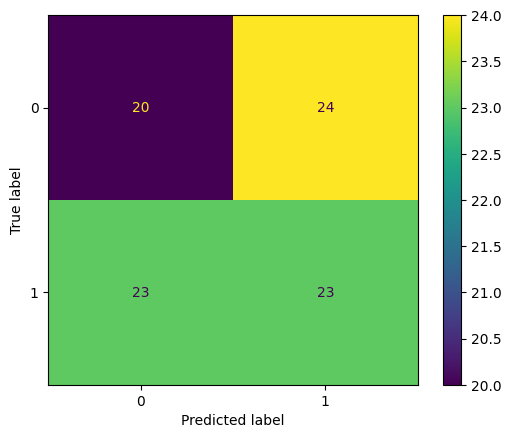

              precision    recall  f1-score   support

    conflict       0.47      0.45      0.46        44
 no-conflict       0.49      0.50      0.49        46

    accuracy                           0.48        90
   macro avg       0.48      0.48      0.48        90
weighted avg       0.48      0.48      0.48        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.47778
conflict_f1-score,0.45977
conflict_precision,0.46512
conflict_recall,0.45455


In [ ]:
from sklearn.linear_model import LogisticRegression


wandb_config['model_name'] = "LR"
wandb_config['feature_level'] = "hidden_states"
wandb_config['data'] = "init_full_1h"
wandb_config['split'] = "no"
wandb_config['feature_set'] = 'wav2vec2-xls-r-300m_random'

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0),
)

cross_validation_n_fold(clf, df_file_hs.loc[:,'hs_0':],
               df_file_hs['label'], wandb_config)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[[18 26]
 [27 19]]


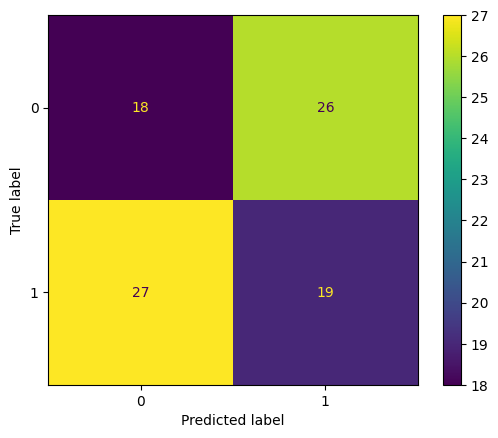

              precision    recall  f1-score   support

    conflict       0.40      0.41      0.40        44
 no-conflict       0.42      0.41      0.42        46

    accuracy                           0.41        90
   macro avg       0.41      0.41      0.41        90
weighted avg       0.41      0.41      0.41        90



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.41111
conflict_f1-score,0.40449
conflict_precision,0.4
conflict_recall,0.40909


In [ ]:
from sklearn.linear_model import LogisticRegression


wandb_config['model_name'] = "LR"
wandb_config['feature_level'] = "extract_features"
wandb_config['data'] = "init_full_1h"
wandb_config['split'] = "no"
wandb_config['feature_set'] = 'wav2vec2-xls-r-300m_random'

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0),
)

cross_validation_n_fold(clf, df_file_ef.loc[:,'ef_0':],
               df_file_ef['label'], wandb_config)

pred_wav2vec2-xls-r-2b_all
no-conflict    516
conflict        29
Name: count, dtype: int64
[[10 29]
 [13 33]]


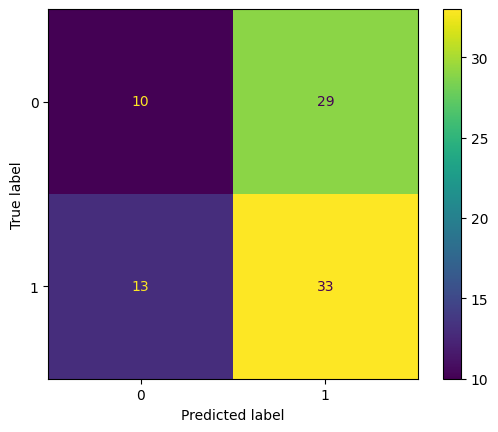

              precision    recall  f1-score   support

    conflict       0.43      0.26      0.32        39
 no-conflict       0.53      0.72      0.61        46

    accuracy                           0.51        85
   macro avg       0.48      0.49      0.47        85
weighted avg       0.49      0.51      0.48        85



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.50588
conflict_f1-score,0.32258
conflict_precision,0.43478
conflict_recall,0.25641


In [ ]:
wandb_config['model_name'] = "LR"
wandb_config['feature_level'] = "hidden_states"
wandb_config['data'] = "init_1h_seg"
wandb_config['split'] = "per-file-all"
wandb_config['max_iter'] = 1000
wandb_config['feature_set'] = 'wav2vec2-xls-r-300m_random'



clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0, max_iter=1000),
)
columns = ['path', 'label'] + list(df_seg_hs.loc[:,'hs_0':].columns)

manual_k_fold(clf, df_seg, df_seg_hs[columns], name='pred_wav2vec2-xls-r-2b_all', wandb_config=wandb_config, cv=5)


pred_wav2vec2-xls-r-300m_random
no-conflict    445
conflict       100
Name: count, dtype: int64
[[22 17]
 [32 14]]


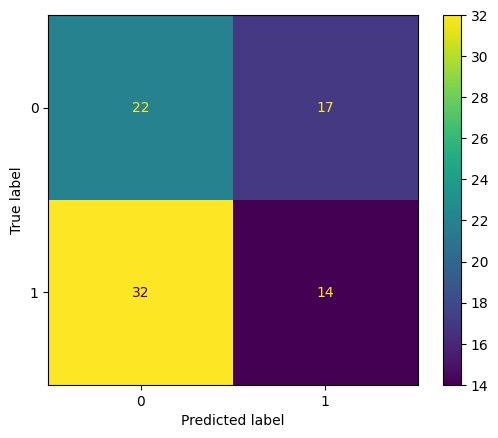

              precision    recall  f1-score   support

    conflict       0.41      0.56      0.47        39
 no-conflict       0.45      0.30      0.36        46

    accuracy                           0.42        85
   macro avg       0.43      0.43      0.42        85
weighted avg       0.43      0.42      0.41        85



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.42353
conflict_f1-score,0.47312
conflict_precision,0.40741
conflict_recall,0.5641


In [ ]:
wandb_config['model_name'] = "LR"
wandb_config['feature_level'] = "extracted_features"
wandb_config['data'] = "init_1h_seg"
wandb_config['split'] = "per-file-all"
wandb_config['max_iter'] = 1000
wandb_config['feature_set'] = 'wav2vec2-xls-r-300m_random'



clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0, max_iter=1000),
)
columns = ['path', 'label'] + list(df_seg_ef.loc[:,'ef_0':].columns)

manual_k_fold(clf, df_seg, df_seg_ef[columns], name='pred_wav2vec2-xls-r-300m_random', wandb_config=wandb_config, cv=5)


In [ ]:
df_seg_hs_300m.columns

Index(['Unnamed: 0', 'res_file_name', 'conversation_folder_name',
       'emotion_context', 'speaker', 'speech_duration', 'language',
       'origin_text', 'emotion_merged', 'label',
       ...
       'hs_1014', 'hs_1015', 'hs_1016', 'hs_1017', 'hs_1018', 'hs_1019',
       'hs_1020', 'hs_1021', 'hs_1022', 'hs_1023'],
      dtype='object', length=1036)

<ipython-input-45-98bb61620475>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seg.loc[k_fold.index, name] = pred


pred_wav2vec2-xls-r-300m_random-no-tune_clients
no-conflict    300
conflict         9
Name: count, dtype: int64
[[ 6 33]
 [ 3 42]]


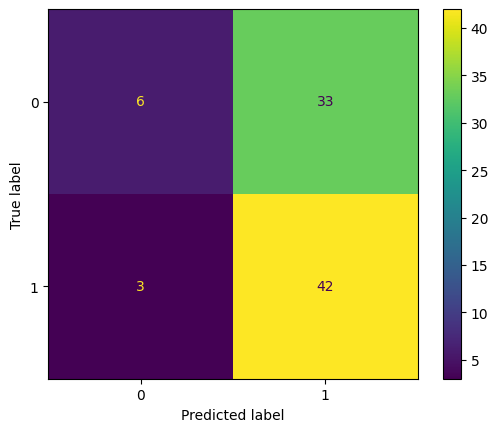

              precision    recall  f1-score   support

    conflict       0.67      0.15      0.25        39
 no-conflict       0.56      0.93      0.70        45

    accuracy                           0.57        84
   macro avg       0.61      0.54      0.48        84
weighted avg       0.61      0.57      0.49        84



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.57143
conflict_f1-score,0.25
conflict_precision,0.66667
conflict_recall,0.15385


In [ ]:
wandb_config['model_name'] = "LR"
wandb_config['feature_level'] = "hidden_states"
wandb_config['data'] = "init_1h_seg"
wandb_config['split'] = "per-file-clients-only"
wandb_config['max_iter'] = 1000
wandb_config['feature_set'] = 'wav2vec2-xls-r-300m_random'



clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0, max_iter=1000),
)
columns = ['path', 'label'] + list(df_seg_hs.loc[:,'hs_0':].columns)

manual_k_fold(clf, df_seg[df_seg['speaker'] != 's'], df_seg_hs[columns], name='pred_wav2vec2-xls-r-300m_random-no-tune_clients', wandb_config=wandb_config, cv=5)


<ipython-input-45-98bb61620475>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seg.loc[k_fold.index, name] = pred


pred_wav2vec2-xls-r-300m_random-no-tune_clients
no-conflict    251
conflict        58
Name: count, dtype: int64
[[17 22]
 [25 20]]


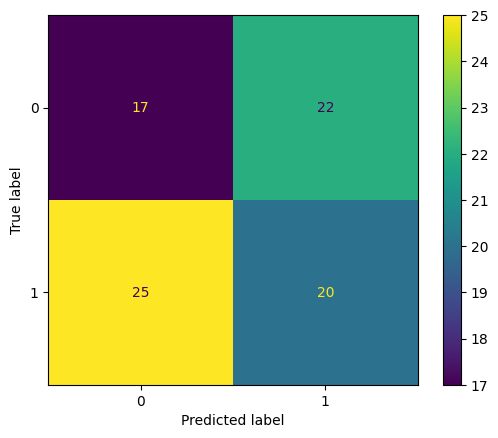

              precision    recall  f1-score   support

    conflict       0.40      0.44      0.42        39
 no-conflict       0.48      0.44      0.46        45

    accuracy                           0.44        84
   macro avg       0.44      0.44      0.44        84
weighted avg       0.44      0.44      0.44        84



accuracy,▁
conflict_f1-score,▁
conflict_precision,▁
conflict_recall,▁
no_conflict_f1-score,▁
no_conflict_precision,▁
no_conflict_recall,▁
accuracy,0.44048
conflict_f1-score,0.41975
conflict_precision,0.40476
conflict_recall,0.4359


In [ ]:
wandb_config['model_name'] = "LR"
wandb_config['feature_level'] = "extracted_features"
wandb_config['data'] = "init_1h_seg"
wandb_config['split'] = "per-file-clients-only"
wandb_config['max_iter'] = 1000
wandb_config['feature_set'] = 'wav2vec2-xls-r-300m_random'



clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=0, max_iter=1000),
)
columns = ['path', 'label'] + list(df_seg_ef.loc[:,'ef_0':].columns)

manual_k_fold(clf, df_seg[df_seg['speaker'] != 's'], df_seg_ef[columns], name='pred_wav2vec2-xls-r-300m_random-no-tune_clients', wandb_config=wandb_config, cv=5)
